In [ ]:
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans

import requests

In [ ]:
breeds = requests.request('GET', 'https://api.thecatapi.com/v1/breeds').json()
breed0 = breeds[0]
numeric_features = []
for key, value in breed0.items():
    if isinstance(value, (int, float)):
        numeric_features.append(key)

numeric_features.remove('lap')  # crutch to fix keyerror, inconsistent api object

colnames = ['id'] + numeric_features
df = pd.DataFrame(columns=colnames)
for breed in breeds:
    row = {key: breed[key] for key in colnames}

    df = df.append(row, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 67 non-null     object
 1   indoor             67 non-null     object
 2   adaptability       67 non-null     object
 3   affection_level    67 non-null     object
 4   child_friendly     67 non-null     object
 5   dog_friendly       67 non-null     object
 6   energy_level       67 non-null     object
 7   grooming           67 non-null     object
 8   health_issues      67 non-null     object
 9   intelligence       67 non-null     object
 10  shedding_level     67 non-null     object
 11  social_needs       67 non-null     object
 12  stranger_friendly  67 non-null     object
 13  vocalisation       67 non-null     object
 14  experimental       67 non-null     object
 15  hairless           67 non-null     object
 16  natural            67 non-null     object
 17 

In [ ]:
df_orig = df.copy()

In [ ]:
df = df_orig.copy()

In [ ]:
df.columns

Index(['id', 'indoor', 'adaptability', 'affection_level', 'child_friendly',
       'dog_friendly', 'energy_level', 'grooming', 'health_issues',
       'intelligence', 'shedding_level', 'social_needs', 'stranger_friendly',
       'vocalisation', 'experimental', 'hairless', 'natural', 'rare', 'rex',
       'suppressed_tail', 'short_legs', 'hypoallergenic'],
      dtype='object')

In [ ]:
df.drop(columns=['indoor',
                 'grooming',
                 'health_issues',
                 'shedding_level',
                 'experimental',
                 'hairless',
                 'natural',
                 'rare',
                 'rex',
                 'suppressed_tail',
                 'short_legs',
                 'hypoallergenic'],
        inplace=True)

-------------------------------------------------------------

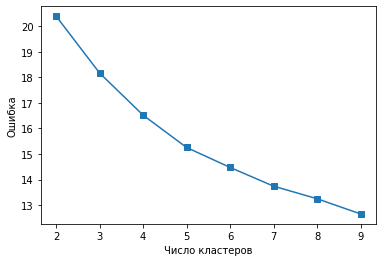

In [ ]:
pd.options.mode.chained_assignment = None
df.dropna()
noid = df.drop(columns=('id'))

scaler = StandardScaler()
scaled = scaler.fit_transform(noid)

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1337).fit(scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 10), inertia, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');


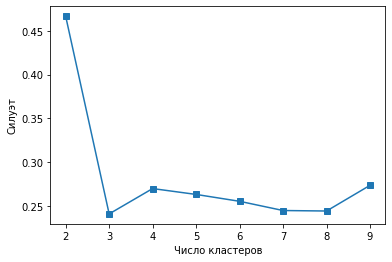

In [ ]:
sil = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1337).fit(scaled)
    sil.append(metrics.silhouette_score(scaled, kmeans.labels_))

plt.plot(range(2, 10), sil, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт');


In [ ]:
# По силуэту имело смысл выбрать 4 кластера однако один из них оказывался малонаполненным так что остановились на трёх.

In [ ]:
kmodel = KMeans(n_clusters=3, random_state=1337)
kmodel.fit(scaled)
df_3clust = df.copy()
df_3clust["cluster"] = kmodel.labels_
df_3clust.groupby("cluster").mean()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adaptability,affection_level,child_friendly,dog_friendly,energy_level,intelligence,social_needs,stranger_friendly,vocalisation
cluster,,,,,,,,,
0,4.966667,5.000000,3.966667,4.866667,4.633333,5.000000,4.633333,4.366667,3.700000
1,5.000000,4.928571,4.000000,4.892857,3.428571,3.964286,3.607143,3.464286,2.000000
2,3.777778,4.222222,2.888889,2.888889,3.000000,3.444444,3.888889,2.444444,2.444444


In [ ]:
df_3clust.cluster.value_counts()

0    30
1    28
2     9
Name: cluster, dtype: int64

In [ ]:
all_handles = []
n_clusters = np.unique(df_3clust["cluster"])
for _ in n_clusters:
    all_handles.append([])

for breed_index, cluster_id in enumerate(df_3clust["cluster"]):
    breed_id = df.iloc[breed_index]['id']
    all_handles[cluster_id].append(breed_id)

for handle in all_handles:
    print(handle)

['abys', 'bali', 'beng', 'bomb', 'bure', 'ctif', 'chee', 'crex', 'cymr', 'drex', 'ebur', 'jbob', 'java', 'kuri', 'lape', 'manx', 'munc', 'ocic', 'orie', 'sava', 'siam', 'sing', 'snow', 'soma', 'sphy', 'tonk', 'toyg', 'tang', 'tvan', 'ycho']
['aege', 'abob', 'acur', 'asho', 'awir', 'amau', 'amis', 'bamb', 'birm', 'bslo', 'bsho', 'buri', 'cspa', 'char', 'chau', 'cypr', 'hbro', 'kora', 'mcoo', 'mala', 'nebe', 'norw', 'pixi', 'raga', 'ragd', 'sfol', 'srex', 'sibe']
['csho', 'dons', 'lihu', 'emau', 'esho', 'hima', 'khao', 'pers', 'rblu']


**Комментарий**

In [ ]:
# В кластеризацию включен набор поведенческих особенностей представленных пород — то, насколько они дружелюбны к чужакам, другим животным, насколько они энергичные и т.д.
# Здесь соответственно выход на шутливую дизайн-гипотезу для нашего бота: человек реагирует на фоточки котиков по их виду, однако такая система потом могла бы потом
# как результат рассказать пользователю о том, какого характера котики ему нравятся
# -
# Кластер 0 (30 пород)
# Крайне умные и ласковые к хозяевам. Очень энергичные, социабельные и дружелюбные к незнакомцам. Самые "разговорчивые" - любят помяукать. Хорошо адаптируются и уживаются с собаками.
# С детьми тоже уживаются неплохо.
# -
# Кластер 1 (29 пород)
# Очень хорошо адаптируются к любым условиям, лучше всех уживаются с детьми и собаками. Ласковые к хозяевам. Умеренно умные и дружелюбные к незнакомцам.
# Не слишком энергичные, не "разговорчивые" и не сильно нуждающиеся в общении и играх с ними.
# -
# Кластер 2 (9 пород)
# Недружелюбные по отношению к незнакомцам. Достаточно ласковые к хозяевам, однако плохо уживающиеся с детьми и собаками. Эти породы наименее энергичные и обладают
# невысоким интеллектом. Достаточно легко адаптирующиеся и социабельные.

------------------------------------------------------------------

In [ ]:
kmodel8 = KMeans(n_clusters=8, random_state=1337)
kmodel8.fit(scaled)
df_8clust = df.copy()
df_8clust["cluster8"] = kmodel8.labels_
df_8clust.groupby("cluster8").mean()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adaptability,affection_level,child_friendly,dog_friendly,energy_level,intelligence,social_needs,stranger_friendly,vocalisation
cluster8,,,,,,,,,
0,5.000000,5.000000,3.857143,4.857143,4.285714,4.857143,4.857143,4.000000,1.428571
1,5.000000,5.000000,4.000000,4.916667,3.833333,4.916667,3.166667,3.916667,2.333333
2,3.666667,4.000000,3.333333,3.333333,3.666667,4.000000,4.000000,3.333333,4.000000
3,5.000000,4.846154,4.000000,4.846154,3.230769,3.000000,3.461538,3.076923,2.538462
4,5.000000,5.000000,2.333333,2.333333,1.666667,3.000000,4.000000,2.000000,1.000000
5,2.000000,5.000000,3.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000
6,4.947368,5.000000,4.052632,4.894737,4.578947,5.000000,4.684211,4.473684,4.526316
7,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.500000,2.000000,2.000000


In [ ]:
df_8clust.cluster8.value_counts()

6    19
0    14
3    13
1    12
2     3
4     3
7     2
5     1
Name: cluster8, dtype: int64

In [ ]:
# https://stackoverflow.com/questions/5452576/k-means-algorithm-variation-with-equal-cluster-size
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np


def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X) / cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1] // cluster_size
    return clusters


clusters = get_even_clusters(X=scaled, cluster_size=23)


In [ ]:
import numpy as np

In [ ]:
df_eqsize = df.copy()
for col in df_eqsize.columns:
    try:
        df_eqsize[col] = df_eqsize[col].astype(np.int64)
    except:
        print('encountered str col')

encountered str col


In [ ]:
df_eqsize['clust_eqsize'] = clusters
df_eqsize.groupby('clust_eqsize').mean()

,adaptability,affection_level,child_friendly,dog_friendly,energy_level,intelligence,social_needs,stranger_friendly,vocalisation
clust_eqsize,,,,,,,,,
0,5.000000,5.000000,4.043478,4.956522,4.695652,5.000000,4.739130,4.478261,3.826087
1,4.428571,4.571429,3.428571,3.809524,3.380952,3.809524,4.142857,3.000000,2.380952
2,5.000000,5.000000,4.000000,5.000000,3.608696,4.217391,3.434783,3.652174,2.217391


In [ ]:
df_eqsize['clust_eqsize'].value_counts()

2    23
0    23
1    21
Name: clust_eqsize, dtype: int64

In [ ]:
all_handles = []
n_clusters = np.unique(clusters)
for _ in n_clusters:
    all_handles.append([])

for breed_index, cluster_id in enumerate(clusters):
    breed_id = df.iloc[breed_index]['id']
    all_handles[cluster_id].append(breed_id)

for handle in all_handles:
    print(handle)

['bali', 'beng', 'bure', 'cymr', 'drex', 'ebur', 'jbob', 'kuri', 'lape', 'manx', 'munc', 'ocic', 'orie', 'sava', 'siam', 'sing', 'snow', 'sphy', 'tonk', 'toyg', 'tang', 'tvan', 'ycho']
['abys', 'aege', 'bsho', 'buri', 'char', 'csho', 'crex', 'dons', 'lihu', 'emau', 'esho', 'hima', 'java', 'khao', 'kora', 'mala', 'nebe', 'pers', 'ragd', 'rblu', 'soma']
['abob', 'acur', 'asho', 'awir', 'amau', 'amis', 'bamb', 'birm', 'bomb', 'bslo', 'cspa', 'ctif', 'chau', 'chee', 'cypr', 'hbro', 'mcoo', 'norw', 'pixi', 'raga', 'sfol', 'srex', 'sibe']


###############################################################################


In [ ]:
clusters

array([1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 1, 2, 2,
       1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0,
       0])